# CENTRALITY IS ALL YOU NEED
## LFN Project

### Description of the project
- **Aim**: try to detect the most influential political figures and their political party.

## Load libraries

In [1]:
#!pip install networkit
#!pip install pyvis
import networkx as nx
import networkit as nk
import csv
import time
from tqdm import tqdm
import pandas as pd
import numpy as np
from pyvis.network import Network
from tqdm import tqdm
import matplotlib.pyplot as plt
import itertools
import seaborn as sns

## Loading of the graph and calculation of some metrics

In [2]:
edges = pd.read_csv("data/fb-pages-politician.edges", sep = ",", header=None)
nodes = pd.read_csv("data/fb-pages-politician.nodes", sep = ",")

In [3]:
nodes

,id,name,new_id
0,127397457601670,陳根德,1661
1,169014523134260,林淑芬,52
2,295363753921281,Chris White,3477
3,613631835423903,Stewart Hosie MP,3193
4,284882801581896,Frank Schäffler,4425
...,...,...,...
5903,342943772496246,Kevin Byrne,3778
5904,193944157325672,Timur Husein,439
5905,142026376065,Jeremy Lefroy,159
5906,294019144024664,Ileana Argentin,107


In [4]:
#needs a dictionary in order to relabel the nodes
labelsDict = pd.Series(nodes.name.values,index=nodes.new_id).to_dict()

In [5]:
G = nx.Graph()
G = nx.from_pandas_edgelist(edges,0, 1)
G = nx.relabel_nodes(G, labelsDict)

In [6]:
G.is_directed()

False

In [7]:
nkG = nk.nxadapter.nx2nk(G)

In [8]:
print("Is G connected? ",nx.is_connected(G))
print("Number of connected components: ", nx.number_connected_components(G))

Is G connected?  True
Number of connected components:  1


In [9]:
#connected components with networkit
cc = nk.components.ConnectedComponents(nkG)
cc.run()
print("number of components ", cc.numberOfComponents())
print("map of component size: ", cc.getComponentSizes())

number of components  1
map of component size:  {0: 5906}


In [10]:
#diameter (estimate)
#This algorithm gives an estimation of the diameter of a given graph. The algorithm is based on the ExactSumSweep algorithm presented in Michele Borassi, Pierluigi Crescenzi, Michel Habib, Walter A. Kosters, Andrea Marino, Frank W. Takes: http://www.sciencedirect.com/science/article/pii/S0304397515001644.
diam = nk.distance.Diameter(nkG,algo=1)
diam.run()
diam.getDiameter() 
#The return value of getDiameter is a pair of integers: the lower bound and upper bound of the diameter. 
#In the case, that we computed the exact diameter, the diameter is the first value of the pair.

(14, 0)

In [11]:
#diameter (effective)
#The effective diameter is defined as the number of edges on average to reach a given ratio of all other nodes.
#The EffectiveDiameter(G, ratio=0.9) constructor expects an undirected graph and the ratio of nodes that should be connected. The ratio must be between in the interval (0,1].
ed = nk.distance.EffectiveDiameter(nkG)
ed.run()
ed.getEffectiveDiameter()

5.816796478157806

In [12]:
#effective diameter approximation
eda = nk.distance.EffectiveDiameterApproximation(nkG)
eda.run()
eda.getEffectiveDiameter()

5.580426684727396

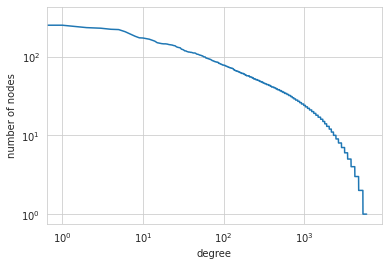

In [13]:
#degree distribution in our original graph
dd = sorted(nk.centrality.DegreeCentrality(nkG).run().scores(), reverse=True)
plt.xscale("log")
plt.xlabel("degree")
plt.yscale("log")
plt.ylabel("number of nodes")
plt.plot(dd)
plt.show()

In [14]:
#some info in our original graph if we are interested
communities = nk.community.detectCommunities(nkG)
nk.community.Modularity().getQuality(communities, nkG)

PLM(balanced,pc,turbo) detected communities in 0.01811385154724121 [s]
solution properties:
-------------------  ----------
# communities         29
min community size    18
max community size   588
avg. community size  203.655
modularity             0.868202
-------------------  ----------


0.8682015102882328

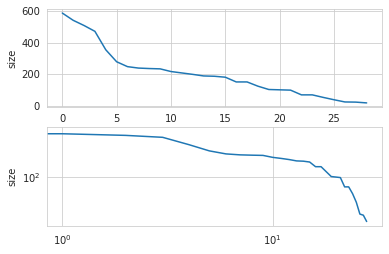

In [15]:
sizes = communities.subsetSizes()
sizes.sort(reverse=True)
ax1 = plt.subplot(2,1,1)
ax1.set_ylabel("size")
ax1.plot(sizes)

ax2 = plt.subplot(2,1,2)
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_ylabel("size")
ax2.plot(sizes)
plt.show()

## Closeness and Betweenness centrality

In [16]:
def centrality(G,alg, lib):
    if alg == "closeness" and lib == "nx":
        start_time = time.time()
        colsenessCentrality_nx = nx.closeness_centrality(G)
        print("--- %s seconds ---" % (time.time() - start_time))
        return colsenessCentrality_nx
    if alg == "betweenness" and lib == "nx":
        start_time = time.time()
        betweennessCentrality_nx = nx.betweenness_centrality(G)
        print("--- %s seconds ---" % (time.time() - start_time))
        return betweennessCentrality_nx
    if alg == "closeness" and lib == "nk":
        start_time = time.time()
        # default normalized=False
        nkColsenessCentrality = nk.centrality.Closeness(G,True,False).run()
        print("--- %s seconds ---" % (time.time() - start_time))
        return nkColsenessCentrality.ranking()
    if alg == "betweenness" and lib == "nk":
        start_time = time.time()
        # default normalized=False
        nkBetweennessCentrality = nk.centrality.Betweenness(G,True,False).run()
        print("--- %s seconds ---" % (time.time() - start_time))
        return nkBetweennessCentrality.ranking()
    if alg == "approxclose" and lib == "nk":
        start_time = time.time()
        # default normalized=False
        nkApproxColsenessCentrality = nk.centrality.ApproxCloseness(G,100, epsilon=0.05, normalized=True).run()
        print("--- %s seconds ---" % (time.time() - start_time))
        return nkApproxColsenessCentrality.ranking()
    if alg == "approxbet" and lib == "nk":
        start_time = time.time()
        nkApproxBetweennessCentrality = nk.centrality.ApproxBetweenness(G,epsilon=0.05).run()
        print("--- %s seconds ---" % (time.time() - start_time))
        return nkApproxBetweennessCentrality.ranking()

In [17]:
#centrality(G,"closeness","nx")

In [18]:
cc = centrality(nkG,"closeness","nk")

--- 0.8033237457275391 seconds ---


In [19]:
top10cc = dict(cc[:10])
keys10cc = list(top10cc.keys())
values10cc = list(top10cc.values())
nodesTop10cc = nodes[nodes["new_id"].isin(keys10cc)]
nodesTop10cc["cc"] = values10cc
nodesTop10cc

<ipython-input-19-eeca2ecd9c7e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodesTop10cc["cc"] = values10cc


,id,name,new_id,cc
385,425788730806692,Pierre Moreau,810,0.358857
1552,1008920055906510,Monika Lazar,219,0.323508
2228,1457854404494601,Hervé Gaymard,233,0.320471
2611,728842613851000,Margaret Quirk MLA,157,0.317422
4205,169196224815,Giovanni Capriglione,50,0.312467
4358,168468263243635,Sylviane Bulteau,703,0.310855
4900,449533531817208,Alejandra Morlan,228,0.309697
5193,336733203010225,Assemblyman Ray Walter,853,0.307536
5227,384662044972285,"Norbert Spinrath, MdB",941,0.305547
5327,232363686957754,Alexander Kulitz,855,0.305152


In [20]:
#centrality(G,"betweenness","nx")

In [21]:
bc = centrality(nkG,"betweenness","nk")

--- 5.0804443359375 seconds ---


In [22]:
top10bc = dict(bc[:10])
keys10bc = list(top10bc.keys())
values10bc = list(top10bc.values())
nodesTop10bc = nodes[nodes["new_id"].isin(keys10bc)]
nodesTop10bc["bc"] = values10bc
nodesTop10bc

<ipython-input-22-148da339cf7a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodesTop10bc["bc"] = values10bc


,id,name,new_id,bc
385,425788730806692,Pierre Moreau,810,0.536616
592,397307097023253,Justine Elliot MP,140,0.111042
2490,229547190392110,"Laurin Liu, Candidate NPD, RDMI",951,0.108292
2611,728842613851000,Margaret Quirk MLA,157,0.096549
2972,662955787059972,Shane King MP- Labor for Kurwongbah,138,0.090176
2981,326547101058452,Reinhard Brandl,255,0.074552
3194,148900938515423,Sofie Carsten Nielsen,177,0.070736
3237,9094598058,Leopoldo Lopez,638,0.068160
4205,169196224815,Giovanni Capriglione,50,0.063586
4358,168468263243635,Sylviane Bulteau,703,0.057986


In [23]:
acc = centrality(nkG,"approxclose","nk")

--- 0.048737525939941406 seconds ---


In [24]:
top10acc = dict(acc[:10])
keys10acc = list(top10acc.keys())
values10acc = list(top10acc.values())
nodesTop10acc = nodes[nodes["new_id"].isin(keys10acc)]
nodesTop10acc["acc"] = values10acc
nodesTop10acc

<ipython-input-24-155343c7ba8d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodesTop10acc["acc"] = values10acc


,id,name,new_id,acc
385,425788730806692,Pierre Moreau,810,0.384615
1552,1008920055906510,Monika Lazar,219,0.330033
2228,1457854404494601,Hervé Gaymard,233,0.325733
4205,169196224815,Giovanni Capriglione,50,0.324675
4358,168468263243635,Sylviane Bulteau,703,0.321543
4900,449533531817208,Alejandra Morlan,228,0.318471
5193,336733203010225,Assemblyman Ray Walter,853,0.316456
5227,384662044972285,"Norbert Spinrath, MdB",941,0.316456
5327,232363686957754,Alexander Kulitz,855,0.315457
5492,150237258650302,Cynthia Viteri,857,0.312500


In [25]:
abc = centrality(nkG,"approxbet","nk")

--- 1.5938286781311035 seconds ---


In [26]:
top10abc = dict(abc[:10])
keys10abc = list(top10abc.keys())
values10abc = list(top10abc.values())
nodesTop10abc = nodes[nodes["new_id"].isin(keys10abc)]
nodesTop10abc["abc"] = values10abc
nodesTop10abc

<ipython-input-26-8006ea99b19e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodesTop10abc["abc"] = values10abc


,id,name,new_id,abc
385,425788730806692,Pierre Moreau,810,0.278919
592,397307097023253,Justine Elliot MP,140,0.058179
2490,229547190392110,"Laurin Liu, Candidate NPD, RDMI",951,0.056468
2611,728842613851000,Margaret Quirk MLA,157,0.043806
2972,662955787059972,Shane King MP- Labor for Kurwongbah,138,0.041410
2981,326547101058452,Reinhard Brandl,255,0.040041
3194,148900938515423,Sofie Carsten Nielsen,177,0.037303
3237,9094598058,Leopoldo Lopez,638,0.036961
4205,169196224815,Giovanni Capriglione,50,0.036277
4358,168468263243635,Sylviane Bulteau,703,0.032854


In [27]:
#visualize a subgraph
#H = G.subgraph(list(G.nodes)[:100])
#nt = Network('900px','1820px')
#nt.from_nx(H)
#nt.show('nx.html')

## Global and local clustering coefficient

In [28]:
#Returns approximate average average local clustering coefficient (networkit)
ACC_nkG = nk.globals.clustering(nkG)
ACC_nkG

0.4324676452705637

In [29]:
#Local Clustering Coefficient does not accept graphs with self loops.
#We remove them and compute the scores 
nkG.removeSelfLoops()
LCC_nkG = nk.centrality.LocalClusteringCoefficient(nkG).run()

In [30]:
len(LCC_nkG.scores()),LCC_nkG.scores()

(5906,
 [0.5739957716701902,
  0.4423558897243108,
  0.5113636363636364,
  0.819047619047619,
  0.7719298245614035,
  0.7333333333333333,
  0.7142857142857143,
  0.3745632424877708,
  0.5032377428307123,
  0.7631578947368421,
  0.3790849673202614,
  0.7350427350427351,
  0.3911421911421911,
  0.2367816091954023,
  0.5231372549019608,
  0.6102418207681366,
  0.5505050505050505,
  0.6628787878787878,
  0.7792207792207793,
  0.6413793103448275,
  0.4117647058823529,
  0.4788732394366197,
  0.7660098522167488,
  0.578494623655914,
  0.25117845117845117,
  0.4767676767676768,
  0.673202614379085,
  0.6773109243697479,
  0.4250380517503805,
  0.3841313269493844,
  0.4231578947368421,
  0.5245143385753932,
  0.8260869565217391,
  0.3886832363828662,
  0.19473180076628352,
  0.6193181818181818,
  0.37462537462537465,
  0.5285024154589372,
  0.8382352941176471,
  0.4919636617749825,
  0.3075091575091575,
  0.20425129900803024,
  0.783625730994152,
  0.4439746300211416,
  0.6623655913978495,
  0

In [31]:
#Returns average clustering coefficient with networkx
ACC_nxG = nx.average_clustering(G)
ACC_nxG

0.38526532797801083

In [32]:
#Networkx does not return an error for the self loops.
#However we obtain a dictionary of the same length, 
#so it removes implicity the self loops
LCC_nxG = nx.clustering(G)
len(LCC_nxG), LCC_nxG

(5906,
 {'Mark Bailey MP - Labor for Miller': 0.5739957716701902,
  'Jo-Ann Miller MP': 0.4423558897243108,
  'Senator Claire Moore': 0.5113636363636364,
  'Shane King MP-  Labor for Kurwongbah': 0.819047619047619,
  'Di Farmer MP': 0.7719298245614035,
  'Leanne Linard MP': 0.7333333333333333,
  'Aaron Harper MP': 0.7142857142857143,
  'Sénateur Pierre-Hugues Boisvenu': 0.3745632424877708,
  'Jackie Trad': 0.5032377428307123,
  'Jim Madden - Labor for Ipswich West': 0.7631578947368421,
  '邱志偉': 0.3790849673202614,
  'Grace Grace MP': 0.7350427350427351,
  'Senator Chris Ketter': 0.3911421911421911,
  'Bill Shorten MP': 0.2367816091954023,
  'Craig Crawford - Labor For Barron River': 0.5231372549019608,
  'Stirling Hinchliffe MP': 0.6102418207681366,
  'Mark Ryan MP': 0.5505050505050505,
  'Dr Anthony Lynham': 0.6628787878787878,
  'Joe Kelly MP': 0.7792207792207793,
  'Linus Power': 0.6413793103448275,
  'Luke Howarth': 0.4117647058823529,
  'Andrew Leigh MP': 0.4788732394366197,
  'Do

## Random Graphs

In [33]:
#Erdös-Renyi model
ERD = nk.generators.ErdosRenyiGenerator(G.number_of_nodes(), 0.2).generate()
print(ERD.numberOfNodes(), ERD.numberOfEdges())
#nk.community.detectCommunities(ERD)

5906 3490715


In [34]:
#Simple variant of Erdös-Renyi model
#The node set is partitioned into a given number of subsets. Nodes within the same subset have a higher edge probability.
CRG = nk.generators.ClusteredRandomGraphGenerator(G.number_of_nodes(), 4, 0.2, 0.002).generate()
print(CRG.numberOfNodes(), CRG.numberOfEdges())
#nk.community.detectCommunities(CRG)

5906 899018


In [35]:
#Chung-Lu model
degreeSequence = [nkG.degree(v) for v in nkG.iterNodes()]
clgen = nk.generators.ChungLuGenerator(degreeSequence)
CLG = clgen.generate()
print(CLG.numberOfNodes(), CLG.numberOfEdges())
cc = nk.components.ConnectedComponents(CLG)
cc.run()
print("number of components ", cc.numberOfComponents())
print("map of component size: ", cc.getComponentSizes())
#nk.community.detectCommunities(CLG)

5906 41300
number of components  330
map of component size:  {0: 5571, 1: 3, 2: 1, 3: 1, 4: 1, 5: 2, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 2, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 2, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 1, 66: 1, 67: 1, 68: 1, 69: 1, 70: 1, 71: 1, 72: 1, 73: 1, 74: 1, 75: 1, 76: 1, 77: 1, 78: 1, 79: 1, 80: 1, 81: 1, 82: 1, 83: 1, 84: 1, 85: 1, 86: 1, 87: 1, 88: 1, 89: 1, 90: 1, 91: 1, 92: 1, 93: 1, 94: 1, 95: 1, 96: 1, 97: 1, 98: 1, 99: 2, 100: 1, 101: 1, 102: 1, 103: 1, 104: 1, 105: 1, 106: 1, 107: 1, 108: 1, 109: 1, 110: 1, 111: 1, 112: 1, 113: 1, 114: 1, 115: 1, 116: 1, 117: 1, 118: 1, 119: 1, 120: 1, 121: 1, 122: 1, 123: 1, 124: 1, 125: 1, 126: 1, 127: 1, 128: 1, 129: 1, 130: 

In [36]:
def generateRandGraphs(alg, nrGraphs, param):
    G = []
    
    if alg == "ER":
        nrNodes, prob = param
        for i in range(nrGraphs):
            ER = nk.generators.ErdosRenyiGenerator(nrNodes, prob).generate()
            G.append(ER)
    if alg == "CL":
        for i in range(nrGraphs):
            degreeSequence = param
            CL = nk.generators.ChungLuGenerator(degreeSequence).generate()
            G.append(CL)
    return G

## Significant check: z-score and p-values

In [37]:
# Generate random graphs
# Compute metricslike E[F(G')], sigma[F(G')] of the random graphs 
# Compute z-score
def zscore(f,expect_FG, sigma_FG):
    #print(f,expect_FG,sigma_FG)
    z = (f - expect_FG)/sigma_FG;
    return z

# Compute p-values
# input: 
#    FG: list of features from graph G'
#    f: float

def pvalues(FG,f):
    plarger = sum(map(lambda x : x>= f, FG))/len(FG)
    psmaller = sum(map(lambda x : x<= f, FG))/len(FG)
    return plarger,psmaller



In [38]:
degreeSequence = [nkG.degree(v) for v in nkG.iterNodes()]

In [65]:
banana = nk.centrality.Closeness(nkG, True, nk.centrality.ClosenessVariant.Generalized)
patata = banana.run()

In [69]:
patata.ranking()

[(703, 0.3588574901245822),
 (853, 0.3235084643620227),
 (941, 0.32047107348312165),
 (855, 0.3174219211955061),
 (228, 0.31246692771721873),
 (157, 0.31085491682459465),
 (50, 0.3096973829128861),
 (219, 0.30753606582990467),
 (810, 0.30554693159474283),
 (233, 0.3051521885173893),
 (177, 0.30491583187028815),
 (857, 0.30389583654984303),
 (147, 0.30261876697586226),
 (209, 0.30087638846428205),
 (424, 0.29979184647408236),
 (948, 0.2995637175324675),
 (1392, 0.2960641764853347),
 (2910, 0.295915810573791),
 (2527, 0.2958120428814748),
 (2123, 0.29579722486600213),
 (34, 0.29533860158047415),
 (255, 0.29471950489119586),
 (214, 0.2946459757497131),
 (57, 0.2932849905632264),
 (2495, 0.2932412971147639),
 (799, 0.29271798939176125),
 (692, 0.29268897149938045),
 (308, 0.29238463061992476),
 (213, 0.28997250049106266),
 (943, 0.28957434287956063),
 (1887, 0.28936149360513547),
 (230, 0.2890357317670093),
 (1576, 0.2890215848465567),
 (138, 0.28893673239712286),
 (247, 0.2887812989045383

In [72]:
def generateDataFrame(G, alg, nrGraphs, algRnd):
    if algRnd == "ER":
        RndGraphs = generateRandGraphs("ER", nrGraphs, [G.numberOfNodes(), 0.0025])
    if algRnd == "CL":
        degreeSequence = [G.degree(v) for v in G.iterNodes()]
        RndGraphs = generateRandGraphs("CL", nrGraphs, degreeSequence)
        
    if alg == "CC":
        #if algRnd == "ER":
        RndFeatures = list(map(
            nk.centrality.Closeness,
            RndGraphs,
            [True for i in range(nrGraphs)],
            [False for i in range(nrGraphs)]
            
        ))
        else:
            RndFeatures = list(map(
                nk.centrality.Closeness,
                RndGraphs,
                [True for i in range(nrGraphs)],
                [nk.centrality.ClosenessVariant.Generalized for i in range(nrGraphs)],
            ))
        RndFeatures = list(tqdm(map(lambda obj: obj.run(), RndFeatures)))
        f = pd.DataFrame(centrality(G,"closeness","nk"))
    if alg == "BC":
        RndFeatures = list(map(nk.centrality.Betweenness,
                               RndGraphs,
                               [True for i in range(nrGraphs)],
                               [False for i in range(nrGraphs)]))
        RndFeatures = list(tqdm(map(lambda obj: obj.run(), RndFeatures)))
        f = pd.DataFrame(centrality(G,"betweenness","nk"))
    if alg == "approxCC":
        RndFeatures = list(map(nk.centrality.ApproxCloseness,
                               RndGraphs,
                               [100 for i in range(nrGraphs)],
                               [0.05 for i in range(nrGraphs)],
                               [True for i in range(nrGraphs)]))
        RndFeatures = list(tqdm(map(lambda obj: obj.run(), RndFeatures)))
        f = pd.DataFrame(centrality(G,"approxclose","nk"))
    if alg == "approxBC":
        RndFeatures = list(map(nk.centrality.ApproxBetweenness,
                               RndGraphs,
                               [0.05 for i in range(nrGraphs)]))
        RndFeatures = list(tqdm(map(lambda obj: obj.run(), RndFeatures)))
        f = pd.DataFrame(centrality(G,"approxbet","nk"))
            
    RndFeaturesRanking = list(map(lambda obj: obj.ranking(), RndFeatures))
    # merge RndFeaturesRanking, we will obtain a list of (key,value) pairs 
    #representing the id of each node as key
    # and the closeness centrality as value
    RndFeaturesRankingMerged = list(itertools.chain(*RndFeaturesRanking))
    RndFeaturesRanking_df = pd.DataFrame(RndFeaturesRankingMerged)
    RndFeaturesRanking_df.columns = {"key":"key", "centrality":"value"}

    mean_by_key = RndFeaturesRanking_df.groupby("key").mean()
    std_by_key = RndFeaturesRanking_df.groupby("key").std()

    f.columns = {"key":"key","centrality":"value"}
    f = f.set_index('key').sort_index()

    zscore_closeness = pd.DataFrame(zscore(f["centrality"],mean_by_key["centrality"],std_by_key["centrality"]))
    zscore_closeness.columns = {"zscore"}
    zscore_closeness["centrality_f"] = f["centrality"]
    zscore_closeness["mean_rand"] = mean_by_key
    zscore_closeness["std_rand"] = std_by_key
    return zscore_closeness

SyntaxError: invalid syntax (<ipython-input-72-13bb88ff7eeb>, line 17)

In [40]:
df_test_BC = generateDataFrame(nkG, "BC", 10, "ER")
df_test_CC = generateDataFrame(nkG, "CC", 10, "ER")
df_test_approxCC = generateDataFrame(nkG, "approxCC", 10, "ER")
df_test_approxBC = generateDataFrame(nkG, "approxBC", 10, "ER")

10it [01:02,  6.23s/it]
0it [00:00, ?it/s]

--- 4.546114921569824 seconds ---


10it [00:05,  1.83it/s]
0it [00:00, ?it/s]

--- 0.4889214038848877 seconds ---


10it [00:00, 19.69it/s]
0it [00:00, ?it/s]

--- 0.047884225845336914 seconds ---


10it [00:11,  1.15s/it]


--- 0.9888513088226318 seconds ---


In [76]:
df_test_BC_CL = generateDataFrame(nkG, "BC", 10, "CL")
df_test_CC_CL = generateDataFrame(nkG, "CC", 10, "CL")
df_test_approxCC_CL = generateDataFrame(nkG, "approxCC", 10, "CL")
df_test_approxBC_CL = generateDataFrame(nkG, "approxBC", 10, "CL")

10it [00:54,  5.47s/it]
0it [00:00, ?it/s]

--- 4.500014781951904 seconds ---


10it [00:04,  2.27it/s]
0it [00:00, ?it/s]

--- 0.4945251941680908 seconds ---


10it [00:00, 23.76it/s]
0it [00:00, ?it/s]

--- 0.04609489440917969 seconds ---


10it [00:08,  1.17it/s]


--- 0.963557243347168 seconds ---


In [82]:
df_test_CC_CL['zscore'].describe()

count    5906.000000
mean       -6.140710
std         6.833081
min       -62.466691
25%        -8.755648
50%        -4.446894
75%        -0.875882
max         4.260718
Name: zscore, dtype: float64

In [88]:
df_test_BC_CL['zscore'].clip(-100, 100).describe()

count    5894.000000
mean        8.516664
std        23.332690
min       -13.282733
25%        -0.969378
50%        -0.372178
75%         4.375364
max       100.000000
Name: zscore, dtype: float64

In [87]:
df_test_BC_CL['zscore'].describe()

count    5894.000000
mean             inf
std              NaN
min       -13.282733
25%        -0.969378
50%        -0.372178
75%         4.375364
max              inf
Name: zscore, dtype: float64

In [91]:
df_test_approxCC_CL['zscore'].describe()

count    5861.000000
mean       -6.457509
std         4.084743
min       -41.841074
25%        -8.569145
50%        -5.513028
75%        -3.616771
max        54.505650
Name: zscore, dtype: float64

Text(0.5, 1.0, 'approxBC')

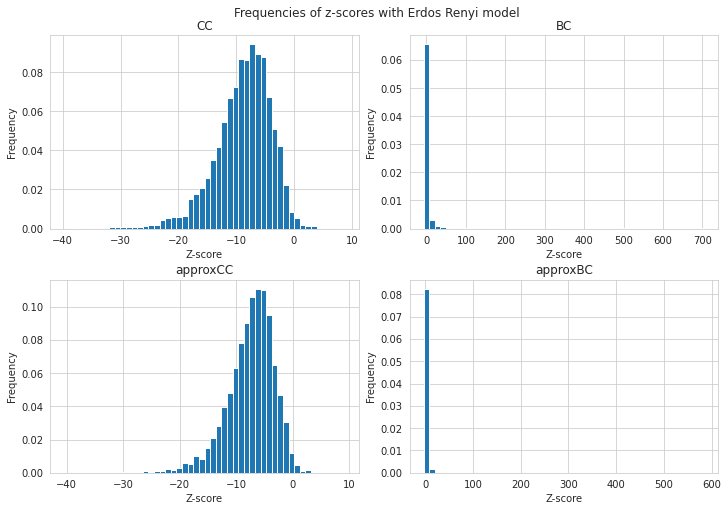

In [106]:
figure, axis = plt.subplots(2, 2, figsize=(10,7))
figure.suptitle("Frequencies of z-scores with Erdos Renyi model")
figure.tight_layout(h_pad=3, w_pad=2)
axis[0,0].hist(df_test_CC['zscore'], density=True, bins=50)
axis[0,0].set_ylabel('Frequency')
axis[0,0].set_xlabel('Z-score')
axis[0,0].set_title('CC')
axis[0,1].hist(df_test_BC['zscore'], density=True, bins=50)
axis[0,1].set_ylabel('Frequency')
axis[0,1].set_xlabel('Z-score')
axis[0,1].set_title('BC')
axis[1,0].hist(df_test_approxCC['zscore'], density=True, bins=50)
axis[1,0].set_ylabel('Frequency')
axis[1,0].set_xlabel('Z-score')
axis[1,0].set_title('approxCC')
axis[1,1].hist(df_test_approxBC['zscore'], density=True, bins=50)
axis[1,1].set_ylabel('Frequency')
axis[1,1].set_xlabel('Z-score')
axis[1,1].set_title('approxBC')

Text(0.5, 1.0, 'approxBC')

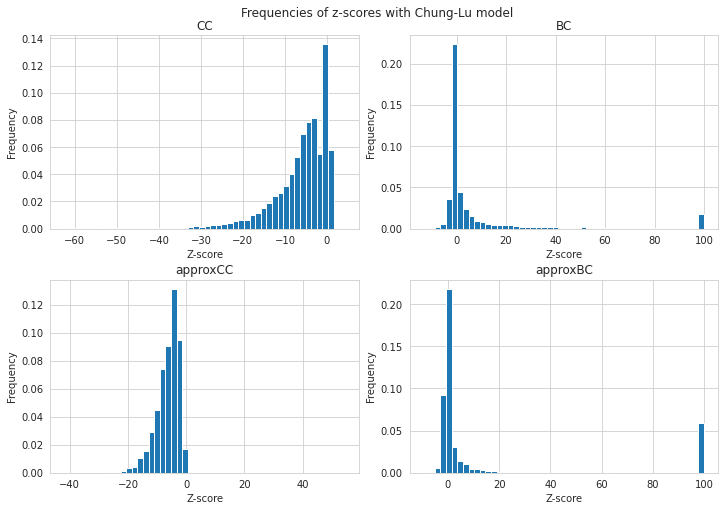

In [107]:
figure, axis = plt.subplots(2, 2, figsize=(10,7))
figure.suptitle("Frequencies of z-scores with Chung-Lu model")
figure.tight_layout(h_pad=3, w_pad=2)
axis[0,0].hist(df_test_CC_CL['zscore'], density=True, bins=50)
axis[0,0].set_ylabel('Frequency')
axis[0,0].set_xlabel('Z-score')
axis[0,0].set_title('CC')
axis[0,1].hist(df_test_BC_CL['zscore'].clip(-100, 100), density=True, bins=50)#clip bc of value inf
axis[0,1].set_ylabel('Frequency')
axis[0,1].set_xlabel('Z-score')
axis[0,1].set_title('BC')
axis[1,0].hist(df_test_approxCC_CL['zscore'], density=True, bins=50)
axis[1,0].set_ylabel('Frequency')
axis[1,0].set_xlabel('Z-score')
axis[1,0].set_title('approxCC')
axis[1,1].hist(df_test_approxBC_CL['zscore'].clip(-100, 100), density=True, bins=50)#clip bc of value inf
axis[1,1].set_ylabel('Frequency')
axis[1,1].set_xlabel('Z-score')
axis[1,1].set_title('approxBC')

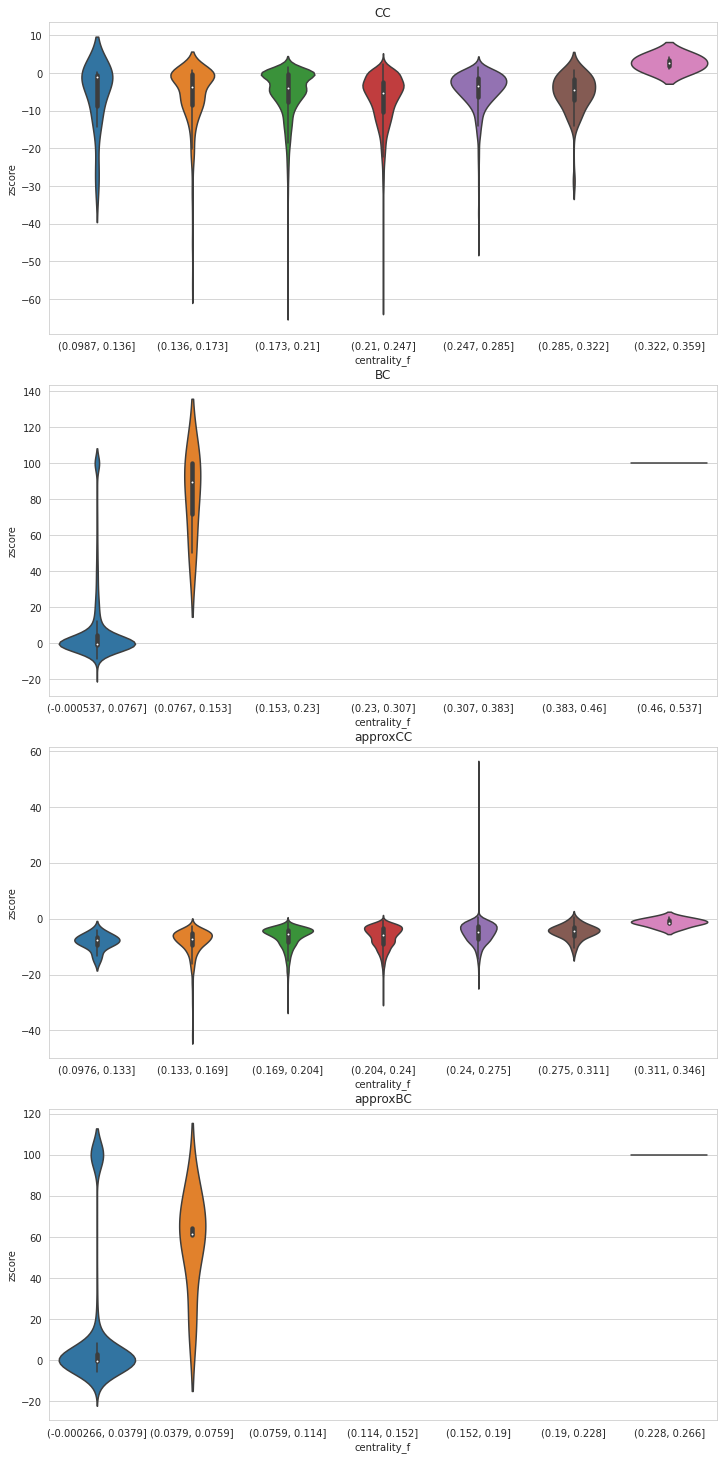

In [98]:
bins=7
df_test_BC_CL['zscore'] = df_test_BC_CL['zscore'].clip(-100,100)
df_test_approxBC_CL['zscore'] = df_test_approxBC_CL['zscore'].clip(-100,100)
fig, axes = plt.subplots(4,1,figsize=(10,20))
fig.tight_layout(h_pad=3)
sns.violinplot(x=pd.cut(df_test_CC_CL['centrality_f'], bins), y='zscore', data=df_test_CC_CL, ax=axes[0])
sns.violinplot(x=pd.cut(df_test_BC_CL['centrality_f'], bins), y='zscore', data=df_test_BC_CL, ax=axes[1])
sns.violinplot(x=pd.cut(df_test_approxCC_CL['centrality_f'], bins), y='zscore', data=df_test_approxCC_CL, ax=axes[2])
sns.violinplot(x=pd.cut(df_test_approxBC_CL['centrality_f'], bins), y='zscore', data=df_test_approxBC_CL, ax=axes[3])
axes[0].set_title("CC")
axes[1].set_title("BC")
axes[2].set_title("approxCC")
axes[3].set_title("approxBC")
plt.show()

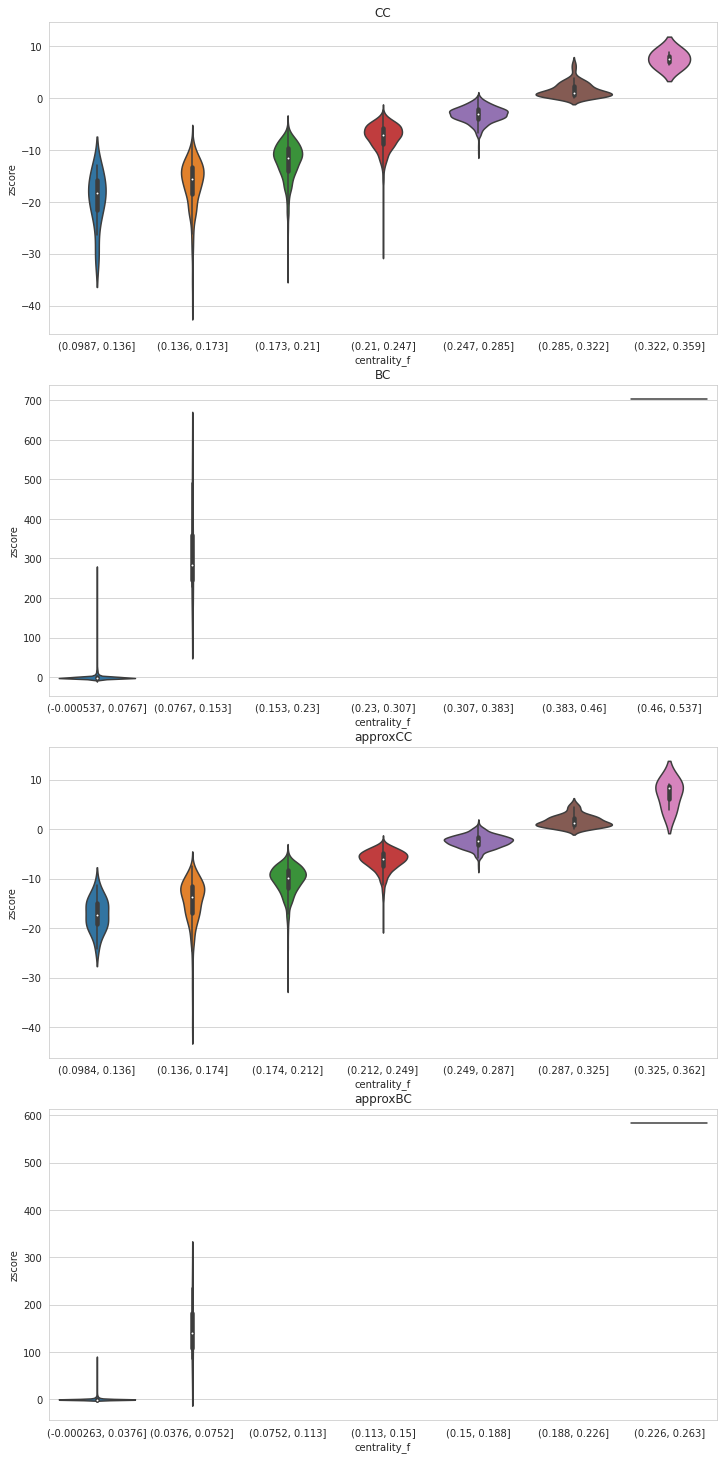

In [96]:
bins=7
fig, axes = plt.subplots(4,1,figsize=(10,20))
fig.tight_layout(h_pad=3)
sns.violinplot(x=pd.cut(df_test_CC['centrality_f'], bins), y='zscore', data=df_test_CC, ax=axes[0])
sns.violinplot(x=pd.cut(df_test_BC['centrality_f'], bins), y='zscore', data=df_test_BC, ax=axes[1])
sns.violinplot(x=pd.cut(df_test_approxCC['centrality_f'], bins), y='zscore', data=df_test_approxCC, ax=axes[2])
sns.violinplot(x=pd.cut(df_test_approxBC['centrality_f'], bins), y='zscore', data=df_test_approxBC, ax=axes[3])
axes[0].set_title("CC")
axes[1].set_title("BC")
axes[2].set_title("approxCC")
axes[3].set_title("approxBC")
plt.show()

In [ ]:
ER_graphs[0].numberOfEdges(),ER_graphs[0].numberOfNodes(),ER_graphs[0].numberOfSelfLoops()

In [ ]:
nkG.numberOfEdges(),nkG.numberOfNodes(),nkG.numberOfSelfLoops()

In [ ]:
avg_CC_randG = list(map(nk.globals.clustering, ER_graphs))
zscore_randG = zscore(ACC_nkG,np.mean(avg_CC_randG), np.std(avg_CC_randG))
print(zscore_randG)

In [ ]:
plarger_, psmaller_ = pvalues(avg_CC_randG, 0.99)
plarger_, psmaller_

In [ ]:
avg_CC_randG